In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 6.9 MB/s 
     |████████████████████████████████| 6.6 MB 50.9 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 596 kB 52.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
#possibly replace with e.g. util.pytorch_cos_sim from sentence_transformers
from scipy.spatial.distance import cosine

from transformers import pipeline
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import AutoTokenizer

#checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="tf")

In [ ]:
from transformers import TFAutoModel

#checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
checkpoint = "bert-base-uncased"
model = TFAutoModel.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
s = "BIPM alumni are in high demand!"
tokens = tokenizer.tokenize(s)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

ids2 = tokenizer(s, padding=True, truncation=True, return_tensors="tf")
print(ids2)

[12170, 9737, 9441, 2024, 1999, 2152, 5157, 999]
{'input_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  101, 12170,  9737,  9441,  2024,  1999,  2152,  5157,   999,
          102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [ ]:
raw_inputs = [
    "How does the dimension of the embedding come about",
    "How do you come around?",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="tf")
print(inputs)

{'input_ids': <tf.Tensor: shape=(2, 13), dtype=int32, numpy=
array([[ 101, 2129, 2515, 1996, 9812, 1997, 1996, 7861, 8270, 4667, 2272,
        2055,  102],
       [ 101, 2129, 2079, 2017, 2272, 2105, 1029,  102,    0,    0,    0,
           0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 13), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 13), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=int32)>}


In [ ]:
import pickle

# Import dataset
TWSM_path="/content/drive/MyDrive/Colab Notebooks/"
decoded_reviews = pickle.load(open(TWSM_path + "data/IMDB/decoded_reviews_train.pkl", "rb"))
train_labels = pickle.load(open(TWSM_path + "data/IMDB/train_labels.pkl", "rb"))

Notice the different ways of calling the tokenizer:

### Tasks:

1. Embedding Similarity 
  * Write a function that takes as input two sentences, finds identical words, computes their contextual embeddings and prints the cosine similarity.
  * Ask interesting questions (case, punctuation,...)
  * Use longer words and find similarity between sub words

2. Load the IMBD reviews and sample 500 positive and negative reviews. 
  * Extract the embedding vectors
  * Fit a Naive Bayes classifier

Embedding similaritiy

In [ ]:
def similarity(s1,s2):
  s = [s1,s2]
  #find similar string
  s1_split = s1.lower().split()
  s2_split = s2.lower().split()
  for w1 in s1_split:
    for w2 in s2_split:
      if w1 == w2:
          print(w1,w2)

  #tokenizing
  input = tokenizer(s, padding=True, truncation=True, return_tensors="tf")
  outputs = model(input)
  
  #convert tokenize to id
  for i, s_t in enumerate(s):
    tokens[i] = tokenizer.tokenize(s_t)
    ids[i] = tokenizer.convert_tokens_to_ids(tokens[i])
    

  #find similar ids
  id_similar, index1, index2 = np.intersect1d(ids[0], ids[1], return_indices=True)
  #plus 1 bc input_ids always start with 101 as default
  d = {"s1": index1+1, "s2": index2+1}
  df = pd.DataFrame(d)

  for i in range(df.shape[0]):
    embed_1 = outputs.last_hidden_state[0,df.iloc[i,0],:]
    embed_2 = outputs.last_hidden_state[1,df.iloc[i,1],:]
    #print(embed_1,embed_2)
    print("similarity:")
    print( 1 - cosine(embed_1, embed_2)) 


In [ ]:
similarity(raw_inputs[0],raw_inputs[1])


how how
come come
similarity:
0.6776947379112244
similarity:
0.47551581263542175


In [ ]:
raw_inputs_2 = ["Should we eat french fries?", "I want to learn French."]
similarity(raw_inputs_2[0],raw_inputs_2[1])

similarity:
0.49993452429771423


In [ ]:
raw_inputs_3 = ["Bark is the outermost layers of trees.", "Your dog bark very loudly."]
similarity(raw_inputs_3[0],raw_inputs_3[1])

bark bark
similarity:
0.22434386610984802
similarity:
0.3719160258769989


Load the IMBD reviews and sample 500 positive and negative reviews.

- Extract the embedding vectors
- Fit a Naive Bayes classifier

In [ ]:
#reload imdb
ReloadIMDB=False

if ReloadIMDB:
  from tensorflow.keras.datasets import imdb
  (train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

  word_index = imdb.get_word_index()
  reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
  
  N=len(train_data)
  decoded_reviews = ["" for x in range(N)]

  for j in range(N):
    decoded_reviews[j] = " ".join(
      [reverse_word_index.get(i - 3, "?") for i in train_data[j]])  
    
    N=len(test_data)
  decoded_reviews_test = ["" for x in range(N)]

  for j in range(N):
    decoded_reviews_test[j] = " ".join(
      [reverse_word_index.get(i - 3, "?") for i in test_data[j]])
    
  pickle.dump(decoded_reviews_test, open(TWSM_path + "data/IMDB/decoded_reviews_test.pkl", "wb"))
  pickle.dump(decoded_reviews, open(TWSM_path + "data/IMDB/decoded_reviews_train.pkl", "wb"))
  pickle.dump(train_labels, open(TWSM_path + "data/IMDB/train_labels.pkl", "wb"))
  pickle.dump(test_labels, open(TWSM_path + "data/IMDB/test_labels.pkl", "wb"))
else:
  decoded_reviews_test = pickle.load(open(TWSM_path + "data/IMDB/decoded_reviews_test.pkl", "rb"))
  decoded_reviews = pickle.load(open(TWSM_path + "data/IMDB/decoded_reviews_train.pkl", "rb"))
  train_labels = pickle.load(open(TWSM_path + "data/IMDB/train_labels.pkl", "rb"))
  test_labels = pickle.load(open(TWSM_path + "data/IMDB/test_labels.pkl", "rb"))

In [ ]:
size = 50

#train data
review_train = pd.DataFrame(decoded_reviews,train_labels).reset_index()
review_train.columns = ["labels","reviews"]
#choose 500 pos & neg reviews
r_train_pos = review_train[review_train["labels"]==1].sample(size)
r_train_neg = review_train[review_train["labels"]==0].sample(size)
r_train = pd.concat([r_train_pos,r_train_neg],axis=0)


In [ ]:
r_train.shape

(100, 2)

In [ ]:
from transformers import AutoTokenizer

#checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
raw_inputs = r_train.reviews.tolist()
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="tf")
print(inputs)

{'input_ids': <tf.Tensor: shape=(100, 512), dtype=int32, numpy=
array([[ 101, 1029, 2023, ...,    0,    0,    0],
       [ 101, 1029, 1045, ...,    0,    0,    0],
       [ 101, 1029, 1045, ...,    0,    0,    0],
       ...,
       [ 101, 1029, 1999, ...,    0,    0,    0],
       [ 101, 1029, 2568, ..., 1055, 2472,  102],
       [ 101, 1029, 1045, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(100, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(100, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


In [ ]:
from transformers import TFAutoModel

#checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
checkpoint = "bert-base-uncased"
model = TFAutoModel.from_pretrained(checkpoint)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
outputs = model(inputs)
print(outputs.last_hidden_state.shape)

(100, 512, 768)


In [ ]:
#reshape to fit sclaer
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train = outputs.last_hidden_state.reshape(size*2, 512*768)
X_train_scaled = mms.fit_transform(X_train)

In [ ]:
y_train = r_train.labels.tolist()

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train_scaled, y_train)

MultinomialNB()

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_train, classifier.predict(X_train_scaled),normalize=True)
print("Train accuracy is ",acc)

Train accuracy is  0.96


In [ ]:
#prepare test data
review_test = pd.DataFrame(decoded_reviews_test,test_labels).reset_index()
review_test.columns = ["labels","reviews"]

#choose 500 pos & neg reviews
r_test_pos = review_test[review_test["labels"]==1].sample(size)
r_test_neg = review_test[review_test["labels"]==0].sample(size)
r_test = pd.concat([r_test_pos,r_test_neg],axis=0)

In [ ]:
raw_inputs_test = r_test.reviews.tolist()
inputs = tokenizer(raw_inputs_test, padding=True, truncation=True, return_tensors="tf")
print(inputs)

{'input_ids': <tf.Tensor: shape=(100, 512), dtype=int32, numpy=
array([[ 101, 1029, 2023, ...,    0,    0,    0],
       [ 101, 1029, 1045, ...,    0,    0,    0],
       [ 101, 1029, 2023, ...,    0,    0,    0],
       ...,
       [ 101, 1029, 2023, ...,    0,    0,    0],
       [ 101, 1029, 7929, ...,    0,    0,    0],
       [ 101, 1029, 1045, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(100, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(100, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


In [ ]:
outputs = model(inputs)
print(outputs.last_hidden_state.shape)

(100, 512, 768)


In [ ]:
X_test = outputs.last_hidden_state.reshape(size*2, 512*768)
X_test_scaled = mms.fit_transform(X_test)

In [ ]:
y_test = r_test.labels.tolist()

In [ ]:
#test accuracy
acc = accuracy_score(y_test, classifier.predict(X_test_scaled),normalize=True)
print("Test accuracy is ",acc)

Test accuracy is  0.53


In [ ]:
y_pred_test = classifier.predict(X_test_scaled)

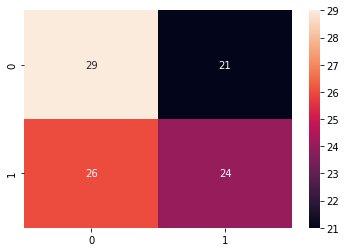

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test,y_pred_test),annot=True,fmt='d')